# PatternNet and PatternLRP: All Methods

*!This notebook will download 1GB of parameters!*

We will show the results of different explanation methods on ImageNet with a VGG16 network.

In the following we will first:

* import and load the data.
* create a VGG16 model with lasagne.
* **create explainers for VGG16 and apply them to the images**.
* plot the result.

Consider also the two other notebooks:

* step_by_step_cifar10: shows how to **compute** patterns and how to apply them on Cifar10.
* step_by_setp_iamgenet: shows how to **apply** an explainer on ImageNet step by step.

### Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

import nn_patterns
import nn_patterns.utils.fileio
import nn_patterns.utils.tests.networks.imagenet
import lasagne
import theano

import imp
eutils = imp.load_source("utils", "./utils.py")

### Data and Parameter loading

We will now download VGG16 parameters and patterns. Finally, we retrieve one image from the ImageNet validation set.

In [2]:
param_file = "./imagenet_224_vgg_16.npz"
# Note those weights are CC 4.0:                                                                                                                                                                                                                                                 
# See http://www.robots.ox.ac.uk/~vgg/research/very_deep/                                                                                                                                                                                                                        
param_url = "https://www.dropbox.com/s/cvjj8x19hzya9oe/imagenet_224_vgg_16.npz?dl=1"

pattern_file = "./imagenet_224_vgg_16.pattern_file.A_only.npz"
pattern_url = "https://www.dropbox.com/s/v7e0px44jqwef5k/imagenet_224_vgg_16.patterns.A_only.npz?dl=1"


# Download the necessary parameters for VGG16 and the according patterns.                                                                                                                                                                                                    
eutils.download(param_url, param_file)
eutils.download(pattern_url, pattern_file)

# Get some example test set images.                                                                                                                                                                                                                                          
images, label_to_class_name = eutils.get_imagenet_data()

## VGG16
We build the VGG16 model and set the trained parameters.

In [3]:
# Create the prediction model and set params.
vgg16 = nn_patterns.utils.tests.networks.imagenet.vgg16()
parameters = nn_patterns.utils.fileio.load_parameters(param_file)
lasagne.layers.set_all_param_values(vgg16["out"], parameters)
predict_f = theano.function([vgg16["input_var"]],
                            lasagne.layers.get_output(vgg16["out"],
                                                      deterministic=True))

## Explanations

We load the patterns and create explainers. Then we apply them to the image. Finally, we postprocess the explanations.

In [4]:
# We want to explain the output neuron with the maximal activation.
target = "max_output"
# Methods we use and some properties.
methods = {
    # NAME         POSTPROCESSING          TITLE                          (GROUP)INDEX

    # Show input.
    "input":      (eutils.original_image,  ("", "Input"),                 (0, 0)      ),

    # Function
    "gradient":   (eutils.back_projection, ("", "Gradient"),              (1, 1)      ),

    # Signal
    "deconvnet":  (eutils.back_projection, ("", "DeConvNet"),             (2, 2)      ),
    "guided":     (eutils.back_projection, ("Guided", "Backprop"),        (2, 3)      ),
    "patternnet": (eutils.back_projection, ("PatterNet", "($S_{a+-}$)"),  (2, 4)      ),

    # Interaction
    "patternlrp": (eutils.heatmap,         ("PatternLRP", "($S_{a+-}$)"), (3, 5)      ),
    "lrp.z":      (eutils.heatmap,         ("", "LRP"),                   (3, 6)      ),
}

# Create explainers.
patterns = nn_patterns.utils.fileio.load_patterns(pattern_file)
explainers = {}
for method in methods:
    explainers[method] = nn_patterns.create_explainer(method,
                                                      vgg16["out"],
                                                      patterns=[patterns])

# Create explanations.
explanations = np.zeros([len(images), len(explainers), 3, 224, 224])
text = []
for i, (image, y) in enumerate(images):
    # Predict label.
    x = eutils.preprocess(image)[None, :, :, :]
    prob = predict_f(x)[0]
    y_hat = prob.argmax()

    text.append((r"\textbf{%s}" % label_to_class_name[y],
                 r"\textit{(%.2f)}" % prob.max(),
                 r"\textit{%s}" % label_to_class_name[y_hat]))

    for eid in explainers:
        # Explain.
        e = explainers[eid].explain(x, target=target)[0]
        # Postprocess.
        e = methods[eid][0](e)
        explanations[i, methods[eid][-1][1]] = e

## Plot

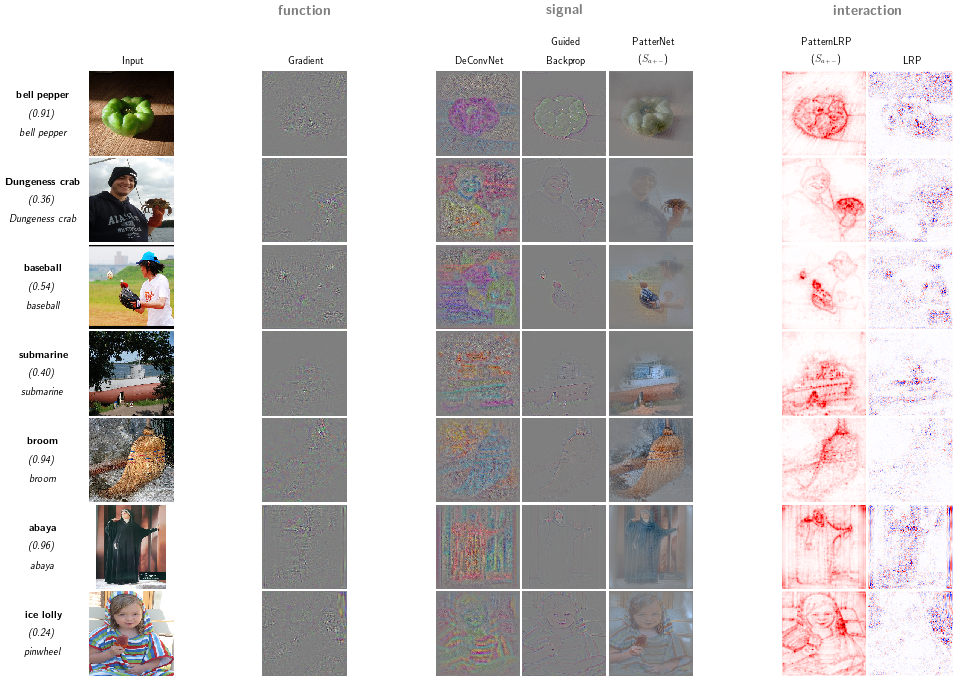

In [8]:
n_samples = len(images)
n_padding = n_samples-1
per_image = 3.2
shape_per_image = [s + n_padding for s in (224, 224)]
big_image = np.ones((3,
                     n_padding + n_samples * shape_per_image[1],
                     n_padding + (3+len(methods)) * shape_per_image[0]),
                    dtype=np.float32)

for i, _ in enumerate(images):
    for eid in explainers:
        egr_idx, e_idx = methods[eid][-1]
        big_image = eutils.put_into_big_image(explanations[i, e_idx],
                                              big_image, i,
                                              e_idx + egr_idx,
                                              n_padding)

group_fontsize = 20
fontsize = 15
plt.figure(figsize=(n_samples * per_image,
                    (3 + len(methods)) * per_image),
           dpi=50)
plt.clf()
plt.imshow(big_image.transpose(1, 2, 0), interpolation="nearest")
plt.tick_params(axis="x", which="both",
                bottom="off", top="off", labelbottom="off")
plt.tick_params(axis="y", which="both",
                bottom="off", top="off", labelbottom="off")
plt.axis("off")
plt.rc("text", usetex=True)
plt.rc("font", family="sans-serif")

# Plot the labels and probability.
for i, s_list in enumerate(text):
    for s, offset in zip(s_list, [-50, 0, 50]):
        plt.text(-120,
                 (offset + n_padding + shape_per_image[0]
                  // 2 + shape_per_image[0] * i),
                 s, fontsize=fontsize, ha="center")

# Plot the methods names.
for eid in methods:
    egr_idx, e_idx = methods[eid][-1]
    s1, s2 = methods[eid][1]
    plt.text((n_padding + shape_per_image[0] // 2
              + shape_per_image[0] * (e_idx+egr_idx)),
             -70, s1, fontsize=fontsize, ha="center")
    plt.text((n_padding + shape_per_image[0] // 2
              + shape_per_image[0] * (e_idx+egr_idx)),
             -20, s2, fontsize=fontsize, ha="center")

# Plot group titles.
for txt, loc in [("function", 5), ("signal", 11), ("interaction", 18)]:
    plt.text(loc * shape_per_image[0] // 2, -160,
             r"\textbf{%s}" % txt, fontsize=group_fontsize, ha="center",
             va="center", color="gray")

plt.show()